In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image, ImageEnhance

import cv2 # this imports OpenCV functions
from PIL import Image, ImageEnhance

from scipy.ndimage.filters import gaussian_filter

data_dir = "C:\\Users\\OliTh\\OneDrive - University of Warwick\\cs933\\Coursework\\cw_data\\DATA\\"
results_dir = "C:\\Users\\OliTh\\OneDrive - University of Warwick\\cs933\\Coursework\\final files\\output1\\"

In [2]:
def read_frames(filename):
    video_cap = cv2.VideoCapture(filename)

    count = 0
    frames = []
    while True:
        success, frame = video_cap.read()

        if success:
            count += 1
            
            # convert from BGR to RGB format
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            frames.append(frame)
        else:
            # print('Failed to read frame') # when last frame read
            break;


    print('Read ', count, ' frames in total')
    video_cap.release()
    
    return frames

def write_frames(frames, filename, codec='H264'):
    
    print('Writing frames to ', filename)
    fourcc = cv2.VideoWriter_fourcc(*codec) # 'MP4V' or 'H264' or VP08/VP09 on DCS computers.T
    writer = cv2.VideoWriter(filename, fourcc, 24, (frames[0].shape[1],frames[0].shape[0]), True)

    for i in range(0,len(frames)):

        frame = cv2.cvtColor(frames[i], cv2.COLOR_RGB2BGR)

        writer.write(frame)

    
    writer.release()
    
video1_frames = read_frames(data_dir + 'video-001.MOV')
video2_frames = read_frames(data_dir + 'video-002.MOV')

Read  217  frames in total
Read  524  frames in total


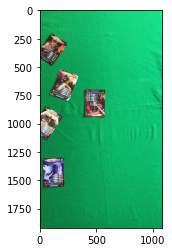

In [3]:
plt.imshow(video1_frames[0])

In [4]:
lower_green = np.array([30, 30, 0])
upper_green = np.array([104, 153, 70])
i=10
lower_green = np.array([0, 30, 30])
upper_green = np.array([120,196,120])

modified_frames = []

for i in range(1):
    frame = video1_frames[i]
    zeros = np.ones_like(frame)
#     plt.subplot(1,2,1)
#     plt.imshow(frame)
    
    mask = cv2.inRange(frame, lower_green, upper_green)
    res = cv2.bitwise_and(frame, frame, mask = mask)
    f = frame - res
    f = np.where(f == 0, 255*zeros, f)
    modified_frames.append(f)
#     plt.subplot(1,2,2)
#     plt.imshow(f)
#     plt.show()

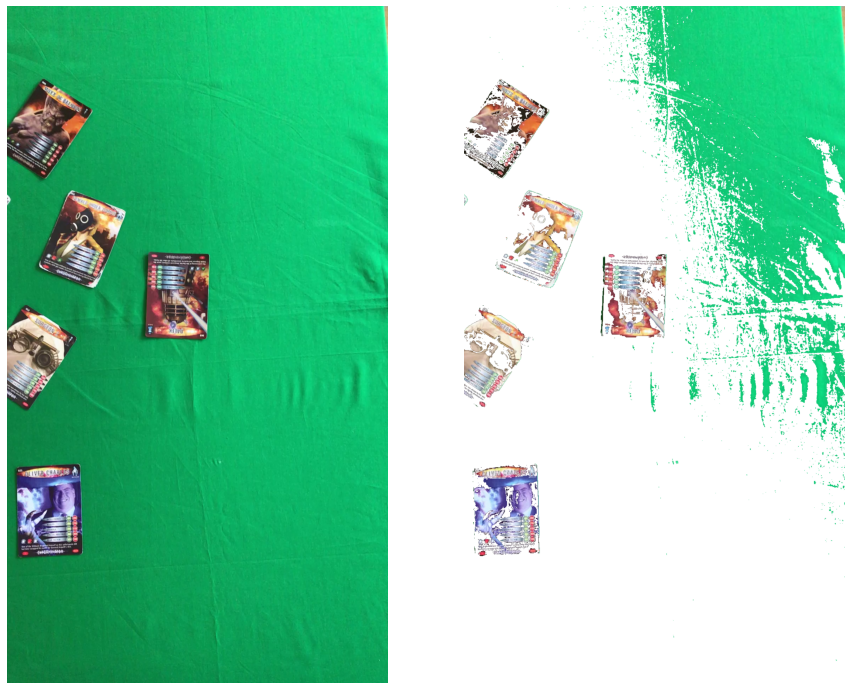

In [5]:
fig = plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(video1_frames[0])
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(modified_frames[0])

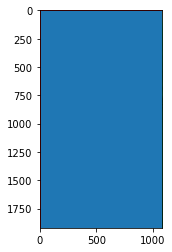

In [6]:
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()

# find the coordinate bounding box of a given label in a components image
def bounding_box(comps, label=1):
    
    # array of image coordinates in x and y
    xx, yy = np.meshgrid(np.arange(0,comps.shape[1]), np.arange(0,comps.shape[0]))

    # mask/select by where value is given label (component)
    where_x = xx[comps==label]
    where_y = yy[comps==label]
    
    # find min and max extents of coordinates
    return np.min(where_x), np.min(where_y), np.max(where_x), np.max(where_y)

import matplotlib.patches as patches
from skimage import measure

for i in range(1): # all frames
    
    frame = video1_frames[i]
    
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    fgmask = fgbg.apply(frame) # extract foreground fgmask


    comps = measure.label(fgmask, background=0) # connected component image

    ax.imshow(frame)

    unique = np.unique(comps)
    
    for l in unique: # each connected component label l
        bb = bounding_box(comps, label=l) # bounding box for a given label

        rect = patches.Rectangle((bb[0],bb[1]),bb[2]-bb[0],bb[3]-bb[1],edgecolor='r')

        ax.add_patch(rect)


    plt.show()

In [7]:
from scipy import signal

def harris(I, window_size, k=0.04):

    dx_kernel = np.array([[-1.0, 1.0], [-1.0, 1.0]])
    dy_kernel = np.array([[-1.0, -1.0], [1.0, 1.0]])
    
    I_f = I # 
    
    # calculate dI/dx, dI/dy, dI/dt by convolutions
    I_x = signal.convolve2d(I_f, dx_kernel, boundary='symm', mode='same')
    I_y = signal.convolve2d(I_f, dy_kernel, boundary='symm', mode='same')
    
    hw = window_size//2
    
    corner_prob = np.zeros(I.shape, dtype='float')
    for i in range(hw, I.shape[0]-hw-1):
        for j in range(hw, I.shape[1]-hw-1):
            
            # local derivatives in x, y and t
            I_xw = I_x[i-hw:i+hw+1, j-hw:j+hw+1].ravel()
            I_yw = I_y[i-hw:i+hw+1, j-hw:j+hw+1].ravel()
            #print('I_tw has shape ', I_tw.shape)

            A = np.vstack((I_xw, I_yw)) # get A here
            
            #print(A.shape)
            M = np.matmul(A, A.T)
            
            #print(M.shape)
            trace = M[0,0] + M[1,1]
            det = M[0,0]*M[1,1]-M[0,1]*M[1,0]
            
            R = det - k * trace*trace
            corner_prob[i,j] = R

    return corner_prob

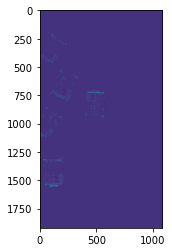

In [8]:
frame = video1_frames[0]

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

corner_prob = harris(frame, 7, k=0.04)

plt.imshow(corner_prob)
plt.show()

In [9]:
from scipy.ndimage.filters import gaussian_filter

frame = video1_frames[0]


output_g_small = gaussian_filter(frame,1)
output_g_big = gaussian_filter(frame,3)

output_dog = output_g_big - output_g_small

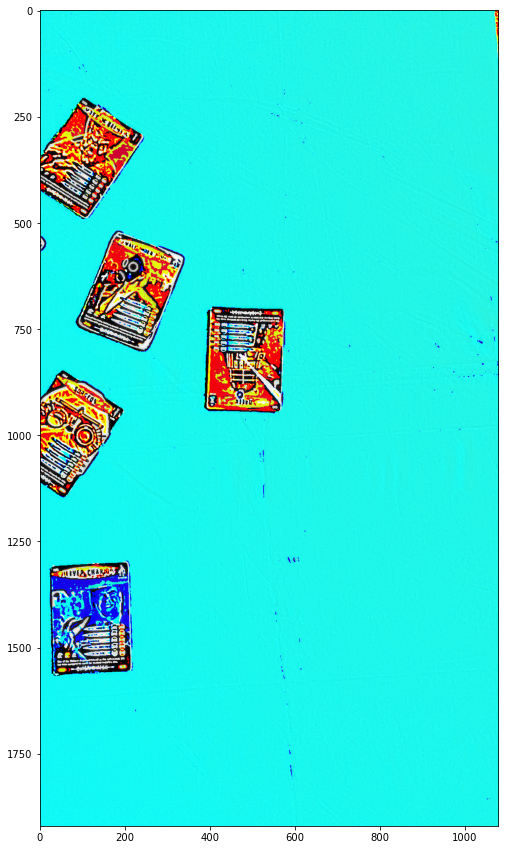

In [10]:
fig = plt.figure(figsize=(15,15))
plt.imshow(output_dog, cmap='gray')
plt.show()

In [11]:
def DoG(frame,BigSigma,SmallSigma):
    return gaussian_filter(frame,BigSigma)-gaussian_filter(frame,SmallSigma)

def Background_Remover(frame):
    
    upper_blue = np.array([ 255, 255, 255])
    lower_blue = np.array([ 0, 220, 220])
    
    frame = DoG(frame,3,1)
    
    zeros = np.ones_like(frame)
#     plt.subplot(1,2,1)
#     plt.imshow(frame)
    
    mask = cv2.inRange(frame, lower_blue, upper_blue)
    res = cv2.bitwise_and(frame, frame, mask = mask)
    f = frame - res
    f = np.where(f == 0, 255*zeros, f)
#     plt.subplot(1,2,2)
#     plt.imshow(f)
#     plt.show()
    return f

In [12]:
frame = output_dog

upper_blue = np.array([ 255, 255, 255])
lower_blue = np.array([ 0, 220, 220])

zeros = np.ones_like(frame)
#     plt.subplot(1,2,1)
#     plt.imshow(frame)

mask = cv2.inRange(frame, lower_blue, upper_blue)
res = cv2.bitwise_and(frame, frame, mask = mask)
f = frame - res
f = np.where(f == 0, 255*zeros, f)

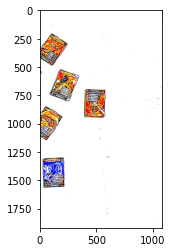

In [13]:
plt.imshow(f)

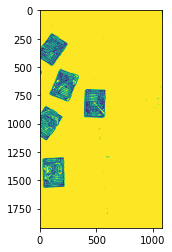

In [14]:
plt.imshow(cv2.cvtColor(f, cv2.COLOR_BGR2GRAY))

In [ ]:
DoG_frames = []
upper_blue = np.array([ 255, 255, 255])
lower_blue = np.array([ 0, 220, 220])

for i in range(len(video1_frames[::10])):
    frame = video1_frames[i]
    frame = DoG(frame,3,1)
    
    zeros = np.ones_like(frame)
#     plt.subplot(1,2,1)
#     plt.imshow(frame)
    
    mask = cv2.inRange(frame, lower_blue, upper_blue)
    res = cv2.bitwise_and(frame, frame, mask = mask)
    f = frame - res
    f = np.where(f == 0, 255*zeros, f)
    DoG_frames.append(f)
#     plt.subplot(1,2,2)
#     plt.imshow(f)
#     plt.show()

In [ ]:
plt.imshow(DoG_frames[0])
f.shape

In [ ]:
def contrast_and_greyscale(imageset,factor):
    contrasted_images = []

    for image in imageset:
        image = Image.fromarray(image)
        contrasted_image = ImageEnhance.Contrast(image)
        im = contrasted_image.enhance(factor)
        gray = cv2.cvtColor(np.asarray(im), cv2.COLOR_BGR2GRAY)
        contrasted_images.append(gray)
    return contrasted_images

# find the coordinate bounding box of a given label in a components image
def bounding_box(comps, label=1):

    # array of image coordinates in x and y
    xx, yy = np.meshgrid(np.arange(0,comps.shape[1]), np.arange(0,comps.shape[0]))

    # mask/select by where value is given label (component)
    where_x = xx[comps==label]
    where_y = yy[comps==label]

    # find min and max extents of coordinates
    return np.min(where_x), np.min(where_y), np.max(where_x), np.max(where_y)

# calculate and plot principal axis of a binarised object
def centroid(im):
    # array of image coordinates in x and y
    xx, yy = np.meshgrid(np.arange(0,im.shape[1]), np.arange(0,im.shape[0]))

    # mask by where im is non-zero
    x = xx[im!=0]
    y = yy[im!=0]
    
    # return the mean of the coordinates of the component
    return np.array([np.mean(x),np.mean(y)])

def principal_axes(im):
    
    m = centroid(im)
    
    # array of image coordinates in x and y
    xx, yy = np.meshgrid(np.arange(0,im.shape[1]), np.arange(0,im.shape[0]))

    # mask by where value is given label and subtract mean positions
    x = xx[im!=0] - m[0] 
    y = yy[im!=0] - m[1]
    
    #print(x.shape)
    #print(y.shape)
    
    # stack all the x and y coordinates into a single two-row matrix (2, N)
    xy = np.vstack((x, y))
    
    # do outer-product matrix - results in a 2x2 matrix
    xy2 = np.matmul(xy, np.transpose(xy))
    
    # find principal eigen vector
    eval, evec = np.linalg.eig(xy2)
    
    #print(eval, evec)
    #print(xy2.shape)
    # get the vector associated with largest eigen value    
    p_axes = np.identity(2)
    if (eval[0]>eval[1]):
        p_axes = evec[0,:]
    else:
        p_axes = evec[1,:]
        
    return p_axes



def rectangle_finder(img,lowerlimit,upperlimit):
    # Load the image
    img = img.copy()

    img_area = img.shape[0]*img.shape[1]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Convert image to binary
    flag, thresh = cv2.threshold(gray, 0, 10, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # Find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    angle_list = [] 
    info_list = []
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)

        #only allow 
        if area > lowerlimit and area < img_area-upperlimit:
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)

            # retrieve parameters of rectangle
            center = (int(rect[0][0]),int(rect[0][1])) 
            width = int(rect[1][0])
            height = int(rect[1][1])
            angle = int(rect[2])

    
            if width < height:
                angle = 90 - angle
            else:
                angle = -angle
                
            info_list.append((angle,center,width,height,box))
#     print(info_list)
    return info_list

Detection

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()

def SDAC(imgset): # return the keypoint and description lists for all images in an imageset.
    kplist = []
    deslist = []
    for i in range(len(imgset)):
        kp,des = sift.detectAndCompute(imgset[i],None)
        kplist.append(kp)
        deslist.append(des)
    return kplist,deslist

import glob
num_classes = 300

images = []
classes = []
            

for label in range(num_classes):

    # e.g. obj10_1.png is image 1 and has label 10
    directory = results_dir + 'obj' + str(label+1).rjust(3,'0') + '_*.jpg'
    
    filenames = glob.glob(directory)
#     print(filenames)
    for j in range(len(filenames)):
        
        im = plt.imread(filenames[j])
        
        images.append(im)
        classes.append(label+1)


kpinfo = SDAC(images)

In [ ]:
from scipy import ndimage
def initial_image_processing(imageset,resizefactor=1,cropfactor=1):#method to process images
    finalimages = []
    for image in imageset:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        height,width = image.shape
        image = image[:int(height/cropfactor),] #cropping
        image = cv2.resize(image,(0,0),fx=resizefactor,fy=resizefactor)
        finalimages.append(image)
    return finalimages

slowimageset = initial_image_processing(images)
fastimageset = initial_image_processing(images,resizefactor=1,cropfactor=2)

slowkpinfo = SDAC(slowimageset)
fastkpinfo = SDAC(fastimageset)

In [ ]:
fastestimageset = initial_image_processing(images,resizefactor=0.5,cropfactor=2)
fastestkpinfo = SDAC(fastestimageset)

plt.subplot(1,2,1)
plt.imshow(fastimageset[0])
plt.subplot(1,2,2)
plt.imshow(fastestimageset[0])

In [ ]:
def fast_flanner(img1,info,scale=1):
    kp_list,des_list = info
    img1 = cv2.resize(img1,(scale*img1.shape[1],scale*img1.shape[0]))
    kp1, des1 = sift.detectAndCompute(img1,None)
    countlist = []
    for j in range(len(kp_list)):
        # FLANN parameters
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)   # or pass empty dictionary

        flann = cv2.FlannBasedMatcher(index_params,search_params) 

        matches = flann.knnMatch(des1,des_list[j],k=2) # find matches!
        # ratio test as per Lowe's paper
        count = 0
        for i,(m,n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                count+=1

        countlist.append(count)
    
    return countlist

In [ ]:
def card_identifier(card,kpinfo,M,scale=1):
    countlist = np.array(fast_flanner(card,kpinfo,scale))
    card_index_list = []
    i = 0
    index_of_max = np.argpartition(countlist,-M)[-M::][::-1]
    while i < M:
        card_index_list.append(index_of_max[i])
        i+=1
    return card_index_list

In [ ]:
card_id_list = ['67', '5', '33', '40', '18', '52', '31', '33', '47', '52', '210', '33', '54', '63', '26', '36', '33', '48', '73', '57', '57', '54', '89', '17', '60', '66', '54', '57', '76', '33', '68', '25', '68', '33', '63', '83', '36', '56', '65', '89', '44', '4', '96', '15', '59', '63', '15', '11', '69', '1', '89', '1', '62', '56', '17', '89', '54', '57', '57', '73', '76', '57', '54', '33', '66', '60', '68', '63', '33', '25', '83', '68', '31', '26', '54', '33', '48', '36', '52', '67', '210', '52', '47', '33', '40', '18', '35', '33', '63', '5', '63', '96', '54', '11', '7', '92', '42', '82', '24', '45', '37', '11', '98', '21', '65', '28', '2', '24', '160', '150', '177', '192', '161', '87', '138', '164', '183', '124', '104', '190', '101', '135', '115', '142', '168', '114', '136', '109', '147', '139', '129', '106', '146', '186', '182', '109', '154', '108', '198', '151', '127', '189', '108', '146', '196', '134', '174', '198', '192', '103', '114', '190', '147', '182', '154', '192', '142', '146', '148', '133', '174', '191', '133', '172', '134', '182', '171', '120', '181', '172', '189', '156', '111', '181', '139', '106', '156', '184', '139', '131', '150', '162', '165', '139', '139', '121', '139', '125', '112', '112', '136', '170', '127', '135', '181', '114', '198', '109', '193', '121', '168', '162', '119', '112', '187', '151', '104', '121', '168']
classes = [1, 1, 2, 4, 5, 5, 7, 11, 11, 11, 15, 15, 17, 17, 18, 18, 21, 24, 24, 25, 25, 26, 26, 28, 31, 31, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 35, 36, 36, 36, 37, 40, 40, 42, 44, 45, 47, 47, 48, 48, 52, 52, 52, 52, 54, 54, 54, 54, 54, 54, 54, 56, 56, 57, 57, 57, 57, 57, 57, 59, 60, 60, 62, 63, 63, 63, 63, 63, 63, 65, 65, 66, 66, 67, 67, 68, 68, 68, 68, 69, 73, 73, 76, 76, 82, 83, 83, 87, 89, 89, 89, 89, 92, 96, 96, 98, 101, 103, 104, 104, 106, 106, 108, 108, 109, 109, 109, 111, 112, 112, 112, 114, 114, 114, 115, 119, 120, 121, 121, 121, 124, 125, 127, 127, 129, 131, 133, 133, 134, 134, 135, 135, 136, 136, 138, 139, 139, 139, 139, 139, 139, 142, 142, 146, 146, 146, 147, 147, 148, 150, 150, 151, 151, 154, 154, 156, 156, 160, 161, 162, 162, 164, 165, 168, 168, 168, 170, 171, 172, 172, 174, 174, 177, 181, 181, 181, 182, 182, 182, 183, 184, 186, 187, 189, 189, 190, 190, 191, 192, 192, 192, 193, 196, 198, 198, 198, 210, 210]

In [ ]:
def rectangle_finder(img,lowerlimit,upperlimit):
    # Load the image
    img = img.copy()

    img_area = img.shape[0]*img.shape[1]

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # binarise image
    flag, thresh = cv2.threshold(img, 0,1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    angle_list = [] 
    info_list = []
    
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
#         print(i,c)
        #only allow 
        if area > lowerlimit and area < img_area-upperlimit:
            
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)

            # retrieve the paramters of rotated rectangle
            center = (int(rect[0][0]),int(rect[0][1])) 
            width = int(rect[1][0])
            height = int(rect[1][1])
            angle = int(rect[2])

    
            if width < height:
                angle = 90 - angle
            else:
                angle = -angle
                
            info_list.append((angle,center,width,height,box))
    return info_list

In [ ]:
def cut_out_cards_rectangle_method(frame):
    
    tinker = 30000
    
    original_frame = frame.copy()
    
    frame = Background_Remover(frame)
    
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    
    ret, frame = cv2.threshold(frame,254,255,cv2.THRESH_BINARY)
    
    frame = cv2.cvtColor(frame,cv2.COLOR_GRAY2BGR)
    
    info_list = rectangle_finder(frame,tinker,10000)
    
    centre_list = []
    for i in range(len(info_list)):
        centre_list.append(info_list[i][1])
            
    
    cut_out_cards = []

    for centre_dim in centre_list:
        minx,maxx = max(0,centre_dim[0]-maxcardlength//2),min(frame.shape[1],centre_dim[0]+maxcardlength//2)
        miny,maxy = max(0,centre_dim[1]-maxcardlength//2),min(frame.shape[0],centre_dim[1]+maxcardlength//2)

        cut_out = original_frame[miny:maxy,minx:maxx]
        cut_out_cards.append(cut_out)
    return cut_out_cards,info_list

def frame_labeller(frame,cut_out_cards,kpinfo,info_list):
    original_frame = frame.copy()
    for i in range(len(info_list)):
        card = cut_out_cards[i]
        index = card_identifier(card,kpinfo,1)
        angle,center,width,height,box = info_list[i]
    #         print(box)
        max_x_value_index = box[:,:1].argmax()
    #         plt.subplot(1,2,1)
    #         plt.imshow(card)
    #         plt.subplot(1,2,2)
    #         plt.imshow(images[index])
    #         plt.show()
#         print(classes[index[0]])
        label = "Card ID: "+str(classes[index[0]])
        textbox = cv2.rectangle(original_frame, (box[max_x_value_index][0], box[max_x_value_index][1]), (box[max_x_value_index][0]+200, box[max_x_value_index][1]+50), (255,255,255), -1)
        cv2.putText(original_frame, label, (box[max_x_value_index][0]+10, box[max_x_value_index][1]+20), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)

        cv2.drawContours(original_frame,[box],0,(255,0,0),2)
    return original_frame


In [ ]:
maxcardlength = 300

frame = video1_frames.copy()[100]

cut_out_cards,info_list = cut_out_cards_rectangle_method(frame)

print('Cards have been cut out.')

frame = frame_labeller(frame,cut_out_cards,kpinfo,info_list)

print('Cards have been identified and labelled on the frame.')

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(frame)

In [ ]:
video1_frames_copy = video1_frames.copy()
modified_video1 = []

for i in range(len(video1_frames_copy)):
    frame = video1_frames_copy[i]
    cut_out_cards,info_list = cut_out_cards_rectangle_method(frame)
    modified_frame = frame_labeller(frame,cut_out_cards,kpinfo,info_list) 
    modified_video1.append(modified_frame)

In [ ]:
# write_frames(modified_video1, results_dir+'test.mp4', codec='H264')

Trying to improve the speed

In [ ]:
def cut_out_cards_rectangle_method(frame):
    
    tinker = 30000
    
    original_frame = frame.copy()
    
    frame = Background_Remover(frame)
    
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    
    ret, frame = cv2.threshold(frame,254,255,cv2.THRESH_BINARY)
    
    frame = cv2.cvtColor(frame,cv2.COLOR_GRAY2BGR)
    
    info_list = rectangle_finder(frame,tinker,10000)
    
    centre_list = []
    for i in range(len(info_list)):
        centre_list.append(info_list[i][1])
            
    
    cut_out_cards = []

    for centre_dim in centre_list:
        minx,maxx = max(0,centre_dim[0]-maxcardlength//2),min(frame.shape[1],centre_dim[0]+maxcardlength//2)
        miny,maxy = max(0,centre_dim[1]-maxcardlength//2),min(frame.shape[0],centre_dim[1]+maxcardlength//2)

        cut_out = original_frame[miny:maxy,minx:maxx]
        cut_out_cards.append(cut_out)
    return cut_out_cards,info_list

def frame_labeller(frame,speed,cut_out_cards,kpinfo,info_list):
    original_frame = frame.copy()
    for i in range(len(info_list)):
        card = cut_out_cards[i]
        index = card_identifier(card,kpinfo,1,speed)
        angle,center,width,height,box = info_list[i]
    #         print(box)
        max_x_value_index = box[:,:1].argmax()
    #         plt.subplot(1,2,1)
    #         plt.imshow(card)
    #         plt.subplot(1,2,2)
    #         plt.imshow(images[index])
    #         plt.show()
#         print(classes[index[0]])
        label = "Card ID: "+str(classes[index[0]])
    #         textbox = cv2.rectangle(original_frame, (center[0]-20, center[1]-100), (center[0] + 200, center[1] + 10), (255,255,255), -1)
        textbox = cv2.rectangle(original_frame, (box[max_x_value_index][0], box[max_x_value_index][1]), (box[max_x_value_index][0]+200, box[max_x_value_index][1]+50), (255,255,255), -1)
        cv2.putText(original_frame, label, (box[max_x_value_index][0]+10, box[max_x_value_index][1]+20), 
        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 1, cv2.LINE_AA)

        cv2.drawContours(original_frame,[box],0,(255,0,0),2)
    return original_frame


In [ ]:
video1_frames = read_frames(data_dir + 'video-001.MOV')
video2_frames = []

fast_modified_video1 = []

speed=1

for i in range(len(video1_frames)):
    print(str(i)+' / '+str(len(video1_frames)))
    frame = video1_frames[i]
    cut_out_cards,info_list = cut_out_cards_rectangle_method(frame)
    print('Cut out cards')
    modified_frame = frame_labeller(frame,speed,cut_out_cards,kpinfo,info_list) 
    print('Identified and labelled cards')
    fast_modified_video1.append(modified_frame)
    
write_frames(fast_modified_video1, results_dir+'results-video-001.mp4', codec='H264')
fast_modified_video1 = []

video1_frames = []

video2_frames = read_frames(data_dir + 'video-002.MOV')
fast_modified_video2 = []

speed=1

for i in range(len(video2_frames)):
    print(str(i)+' / '+str(len(video2_frames)))
    frame = video2_frames[i]
    cut_out_cards,info_list = cut_out_cards_rectangle_method(frame)
    print('Cut out cards')
    modified_frame = frame_labeller(frame,speed,cut_out_cards,kpinfo,info_list) 
    print('Identified and labelled cards')
    fast_modified_video2.append(modified_frame)
    
write_frames(fast_modified_video2, results_dir+'results-video-002.mp4', codec='H264')
video2_frames = []

Trying to optimize even further for speed

In [ ]:
fastest_modified_video1 = []

f=0.1

for i in range(len(video1_frames)):
    print(str(i)+' / '+str(len(video1_frames)))
    frame = video1_frames[i]
    cut_out_cards,info_list = cut_out_cards_rectangle_method(frame)
    print('Cut out '+str(len(cut_out_cards)) +' cards')
    resized_cut_out_cards = []
    for im in cut_out_cards:
        im1 = cv2.resize(im,(0,0),fx=f,fy=f)
        resized_cut_out_cards.append(im1)
    modified_frame = frame_labeller(frame,1,resized_cut_out_cards,fastestkpinfo,info_list) 
    print('Identified and labelled cards')
    fastest_modified_video1.append(modified_frame)

In [ ]:
frame = video1_frames.copy()[100]

cut_out_cards,info_list = cut_out_cards_rectangle_method(frame)

print('Cards have been cut out.')
f=0.1
resized_cut_out_cards = []
for im in cut_out_cards:
    im1 = cv2.resize(im,(0,0),fx=f,fy=f)
    resized_cut_out_cards.append(im1)

frame = frame_labeller(frame,1,resized_cut_out_cards,fastestkpinfo,info_list)

print('Cards have been identified and labelled on the frame.')

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(frame)